In [83]:
from nltk.tokenize import word_tokenize
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from transformers import XLNetTokenizer

In [84]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [85]:
with open('../data/input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [86]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [87]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

In [88]:
def split_newline(text):
    text = text.split(' ')
    
    for i, substring in enumerate(text):
        # detect substring containing the newline symbol '\n'
        if '\n' in substring:
            # split the substring by characters
            chars = [c for c in substring]
            
            sindex = 0
            split_substring_list = []
            for j, char in enumerate(chars):
                # When meets a newline, append all previous chars as a substring ([sindex:j])
                if char == '\n':
                    c_chars = ''.join(chars[sindex:j])
                    if  c_chars != '':
                        split_substring_list.append(c_chars)
                    # Then added the '\n'
                    split_substring_list.append('\n')
                    # Update the sindex
                    sindex = j + 1
            # Added the rest of all chars as a substring
            split_substring_list.append(''.join(chars[sindex:]))
            # Replace the original string by a list of string
            text[i] = split_substring_list
        else:
            # warp other items as a list
            text[i] = [substring]
    
    # Flatten the 
    return flatten(text)

def tokenization(text):
    for i, token in enumerate(text):
        # print(token)
        if token == '\n':
            continue
        text[i] = tokenizer.tokenize(token)
    
    return flatten(text)

In [89]:
processed_text = (tokenization(split_newline(text)))

In [90]:
words = sorted(list(set(processed_text)))
vocab_size = len(words)
print(f'TOTAL words num: {len(words)}')

# create a mapping from characters to integers
stoi = { w:i for i,w in enumerate(words) }
itos = { i:w for i,w in enumerate(words) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]).replace('▁', ' ') # decoder: take a list of integers, output a string

# encode the entire text dataset and store it into a torch.Tensor
data = torch.tensor(encode(processed_text), dtype=torch.long)

TOTAL words num: 9669


In [91]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]
print(f'The size of train data is : {len(train_data)}')
print(f'The size of val data is : {len(val_data)}')

The size of train data is : 319013
The size of val data is : 35446


In [92]:
torch.manual_seed(1337)
batch_size = 4 # How many independent sequences will be process in parallel?
block_size = 8 # What is the maximum context length for predictions?

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
def get_batch(batch_size, block_size, split):
    data = train_data if split == 'train' else val_data
    
    sindex = 0
    eindex = batch_size * block_size
    while eindex < (len(data) - block_size):
        # Extract batch_size * block_size tokens in the data
        xb = data[sindex: eindex]
        yb = data[sindex+1: eindex+1]
        # Reshape the batch by the shape (batch_size, block_size)
        xb = xb.reshape(batch_size, block_size)
        yb = yb.reshape(batch_size, block_size)
        # Update the indexes for extracting tokens sections
        temp = eindex
        eindex = eindex + block_size * batch_size
        sindex = temp
        yield xb.to(DEVICE), yb.to(DEVICE)
    
    # For the last batch that cannot be batched as in the size (batch_size, block_size)
    # Maintain the 'block_size' dimension
    if eindex >= (len(data) - block_size):
        # The number of useable completed sample including 'block_size' elements
        num_sample = (len(data) - sindex) // block_size 
        if num_sample >= 1:
            xb = data[sindex: sindex + (num_sample * block_size)]
            yb = data[sindex+1: sindex + (num_sample * block_size)+1]
            xb = xb.reshape(num_sample, block_size)
            yb = yb.reshape(num_sample, block_size)
            yield xb.to(DEVICE), yb.to(DEVICE)

In [ ]:
for i, batch in enumerate(get_batch(batch_size, block_size, 'train')):
    xb, yb = batch
    if i < 1:
        print('inputs:')
        print(xb.shape)
        print(xb)
        print('targets:')
        print(yb.shape)
        print(yb)

inputs:
torch.Size([4, 8])
tensor([[3009, 2545,   80,    7,    0, 2682, 9475, 7773],
        [4257, 6117,    4, 6363, 7025, 8635,    6,    0],
        [   0, 2594,    7,    0, 2545,  314, 1818,    4],
        [8635,    6,    0,    0, 3009, 2545,   80,    7]], device='cuda:0')
targets:
torch.Size([4, 8])
tensor([[2545,   80,    7,    0, 2682, 9475, 7773, 4257],
        [6117,    4, 6363, 7025, 8635,    6,    0,    0],
        [2594,    7,    0, 2545,  314, 1818,    4, 8635],
        [   6,    0,    0, 3009, 2545,   80,    7,    0]], device='cuda:0')


In [ ]:
# for b in range(batch_size): # batch dimension
#     print(f'batch {b+1}/{batch_size}')
#     for t in range(block_size): # time dimension
#         context = xb[b, :t+1]
#         target = yb[b,t]
#         print(f"when input is {context.tolist()} the target: {target}")
#     print()

In [ ]:
# hyperparameters
batch_size = 32 # how many independent sequences will we process in parallel?
block_size = 128 # what is the maximum context length for predictions?
max_iters = 2000
eval_interval = 500
learning_rate = 3e-4
eval_iters = 150
n_embd = 256
n_head = 16
n_layer = 8
dropout = 0.3
# ------------

In [ ]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=DEVICE)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [ ]:
model = GPTLanguageModel()
model.to(DEVICE)

GPTLanguageModel(
  (token_embedding_table): Embedding(9669, 256)
  (position_embedding_table): Embedding(128, 256)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-15): 16 x Head(
            (key): Linear(in_features=256, out_features=16, bias=False)
            (query): Linear(in_features=256, out_features=16, bias=False)
            (value): Linear(in_features=256, out_features=16, bias=False)
            (dropout): Dropout(p=0.3, inplace=False)
          )
        )
        (proj): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Linear(in_features=256, out_features=1024, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1024, out_features=256, bias=True)
          (3): Dropout(p=0.3, inplace=False)
        )
      )
      (ln1): LayerNorm((256,), eps=1e-05, elementwise_aff

In [ ]:
params = sum(p.numel() for p in model.parameters())
print(params/1e6, 'M parameters')

11.305413 M parameters


In [ ]:
# create a PyTorch optimizer and the scheduler for lr adjusting
lr = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

In [ ]:
epochs = 3
num_checkpoints = 4
batch_size_increase_interval = 1
batch_size_increase_rate = 2

batch_size = 16
block_size = 32
train_eval_iters = math.ceil(len(train_data) / (batch_size * block_size))
val_eval_iters = math.ceil(len(val_data) / (batch_size * block_size))
print(train_eval_iters, val_eval_iters)

checkpoints = [i for i in range(0, train_eval_iters+1, train_eval_iters // num_checkpoints)]
checkpoints[-1] = train_eval_iters
print(checkpoints[1:])

624 70
[156, 312, 468, 624]


In [ ]:
def update_batch_size(batch_size, block_size, increase_rate):
    batch_size = batch_size * increase_rate
    
    train_eval_iters = math.ceil(len(train_data) / (batch_size * block_size))
    val_eval_iters = math.ceil(len(val_data) / (batch_size * block_size))
    
    checkpoints = [i for i in range(0, train_eval_iters+1, train_eval_iters // num_checkpoints)]
    checkpoints[-1] = train_eval_iters

    return batch_size, train_eval_iters, val_eval_iters, checkpoints

In [ ]:
@torch.no_grad()
def estimate_loss(train_eval_iters, val_eval_iters):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        eval_iters = train_eval_iters if split == 'train' else val_eval_iters
        losses = torch.zeros(eval_iters)
        for i, batch in enumerate(get_batch(batch_size, block_size, split)):
            X, Y = batch
            _, loss = model(X, Y)
            losses[i] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [ ]:
from tqdm import tqdm
from colorama import Fore, Style

train_losses_list = []
val_losses_list = []

init_loss = estimate_loss(train_eval_iters, val_eval_iters)
print(f"Initial Loss: train loss train loss {init_loss['train']:.4f}, val loss {init_loss['val']:.4f}")

for e in range(epochs):
    print(f'Epoch: {e+1}/{epochs}:=====================')
    print(f'Current lr: {scheduler.get_last_lr()}')
    
    if e % batch_size_increase_interval == 0:
        batch_size, train_eval_iters, val_eval_iters, checkpoints = update_batch_size(batch_size, block_size, batch_size_increase_rate)
    print(f'Current batch_size: {batch_size}, block_size: {block_size}')

    for i, batch in enumerate(tqdm(get_batch(batch_size, block_size, 'train'), total=train_eval_iters)):
        
        # Checkpoints for model training validation
        if i in checkpoints[1:] or i == train_eval_iters - 1:
            losses = estimate_loss(train_eval_iters, val_eval_iters)
            print(Fore.GREEN + 
                  f"step {i+1}/{train_eval_iters}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        
        # Get batch and loss
        xb, yb = batch
        logits, loss = model(xb, yb)
        
        # Record the val and train loss for later visualization
        train_losses_list.append(losses['train'])
        val_losses_list.append(losses['val'])
        
        # Optimize the model parameters
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
    
    # Schedule the learning rate by step size
    scheduler.step()
    
    print(Style.RESET_ALL)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
start_token_string = 'All'
start_token = torch.tensor(stoi[start_token_string], dtype=torch.long, device=DEVICE).view(-1, 1)

print(decode(model.generate(start_token, max_new_tokens=1000)[0].tolist()))

Allvasre
 Will I needs think your pity for thou then? These Commands't, to be gone.

 EScal sail of your treasures:
 LADY  mistakes, for good, as Then,
 Would ever use where laid your garden upon me.
 Ready, I be true: for myself, you art:
 I pray my lord have trew them and
 thisbow breathed.

rew attach; for I will speak your pound:
 Marry-cant, dispatch. care, and it'd,
 Happilyd, for thee above the king,
 Left lions in him; none but I hope you know his
marsh Third met.

 Provost:
 Come not to have thee he the reins of his sense
 With all retire: think who you are nature made with
 your state my brazen mockiered lip, or Let's judge, and I get in love
 To lock King multi groaning into sounds, and it sea:
PETmen, yess 'gainst the reverence of my peril.

 BENVOLIO:
 One allied, sir, lest your eyes,
 With this gentleman; but thou art matter.

 EDWARD:
 Well, your honour, madam, I did with of me!

 LUCIO:
 Let us desire ins; for trust you, sir, my lady;
 O thou arttouncet the villain of t

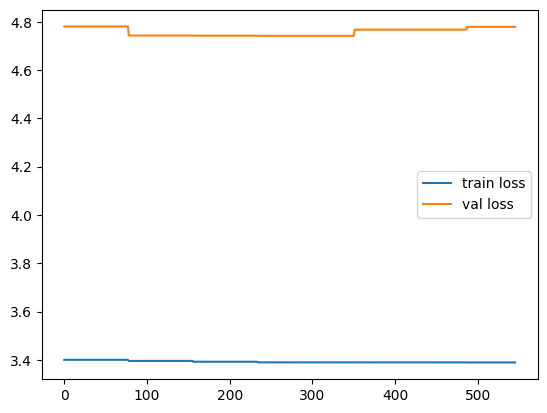

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses_list, label="train loss")
plt.plot(val_losses_list, label="val loss")
plt.legend()
plt.show()

In [ ]:
from datetime import date

model_size_str = str(int(params/1e6))
model_file_name = 'word_transformer' + model_size_str + 'M-'+ str(date.today()) +'.pth'
model_save_path = '../params/transformer/' + model_file_name
torch.save(model.state_dict(), model_save_path)
print("The model saved successfully.")

The model saved successfully.
